# Project: Investigate Gapminder Data on Countries Globally

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Datasets Chosen*:
1. **Forest Coverage:** Percentage of total land area that has been covered with forest during the given year.
2. **Math Achievement:** Average score in the international TIMSS test for 4th grade children.
3. **Murders/100000p:** Mortality due to interpersonal conflict per, per 100 000 standard population, age adjusted. This rate is calculated as if all countries had the same age composition of the population.
4. **Population Density:** Average number of people on each square km of the land in the given country.

*All data was publicly available and pulled from <https://www.gapminder.org/data/>

### Questions
1. How are each of the datasets trending over time when countries are averaged together to give a more global viewpoint?
2. How does a select number of countries perform compared to the global average?
3. Whats correlations are there, if any, between the global averages over a set time frame? 

In [878]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [879]:
#reading the .csv files into DataFrames to be explored using pandas
df_forest = pd.read_csv('forest_coverage_percent.csv')
df_math = pd.read_csv('math_achievement_4th_grade.csv')
df_murder = pd.read_csv('murder_per_100000_people.csv')
df_pop = pd.read_csv('population_density_per_square_km.csv')

In [880]:
#setting the first column as the index for all df
df_forest.set_index('country', inplace=True)
df_math.set_index('country', inplace=True)
df_murder.set_index('country', inplace=True)
df_pop.set_index('country', inplace=True)

In [881]:
#converting column labels to datetimeIndex
df_forest.columns = pd.to_datetime(df_forest.columns)
df_math.columns = pd.to_datetime(df_math.columns)
df_murder.columns = pd.to_datetime(df_murder.columns)
df_pop.columns = pd.to_datetime(df_pop.columns)

In [882]:
#transposing all dataframes so datetimeIndex will work properly
df_forest = df_forest.transpose()
df_math = df_math.transpose()
df_murder = df_murder.transpose()
df_pop = df_pop.transpose()

##### Additional exploration was performed using the Spyder IDE, with the most important pieces copied below.

In [883]:
#looking at shapes of the 4 data sets
data = [df_forest, df_math, df_murder, df_pop]
data_names = ["Forest", "Math", "Murder", "Population"]
for i in range(len(data)):
    print(data_names[i] + ':' + str(data[i].shape))

Forest:(26, 192)
Math:(13, 35)
Murder:(67, 103)
Population:(151, 195)


In [884]:
#finding date ranges for data
for i in range(len(data)):
    print(data_names[i] + ' Date Range: ' + str(data[i].index.year.values.tolist()[0]) + '-' \
          + str(data[i].index.year.values.tolist()[-1]))

Forest Date Range: 1990-2015
Math Date Range: 1995-2007
Murder Date Range: 1950-2016
Population Date Range: 1950-2100


#### Math data only actually exists for 3 years out of the range, and the Population data extends into the future, so I will truncate them in the "data wrangling" phase for easier comparability between sets.

In [885]:
df_forest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 1990-01-01 to 2015-01-01
Columns: 192 entries, Afghanistan to Zimbabwe
dtypes: float64(192)
memory usage: 39.2 KB


In [886]:
#seeing if I need to deal with NaN values in df_pop, since I can't see from .info
df_forest.isna().sum().sum()

110

This set looks relatively clean, but the first few years of underrepresentation of countries might be trimmed

In [887]:
df_math.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 1995-01-01 to 2007-01-01
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Algeria               1 non-null      float64
 1   Armenia               2 non-null      float64
 2   Australia             3 non-null      float64
 3   Austria               2 non-null      float64
 4   Canada                3 non-null      float64
 5   Colombia              1 non-null      float64
 6   Czech Republic        2 non-null      float64
 7   Denmark               1 non-null      float64
 8   El Salvador           1 non-null      float64
 9   Georgia               1 non-null      float64
 10  Germany               1 non-null      float64
 11  Hungary               3 non-null      float64
 12  Iran                  3 non-null      float64
 13  Italy                 2 non-null      float64
 14  Japan                 3 non-null      float64
 15  Kazak

In [888]:
df_math.isna().sum().sum()

386

In [889]:
df_murder.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 1950-01-01 to 2016-01-01
Columns: 103 entries, Albania to Venezuela
dtypes: float64(103)
memory usage: 54.4 KB


In [890]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 1950-01-01 to 2100-01-01
Columns: 195 entries, Afghanistan to Zimbabwe
dtypes: float64(195)
memory usage: 231.2 KB


In [891]:
df_pop.isna().sum().sum()

0

In [892]:
#checking for duplicates
for i in range(len(data)):
    print(data_names[i] + ': ' + str(data[i].duplicated().sum()))

Forest: 0
Math: 9
Murder: 0
Population: 0


these 9 rows in the math data are empty years, so they'll be removed.


#### Exploration Conclusions
Qatar and San Marino seem like an error because they have 0 forest coverage for all time, but they both just happen to be tiny countries that are completely unforested.  
There are many null values that I will take care of in the data cleaning phase, which are probably due to countries not reporting to whatever database this was at certain times. I will seek to keep as many consecutively reporting countries as I can for the longest period reasonable.

### Data Cleaning
I'm going to work on df_math first, because it has the most unique shape and will not have good direct comparability with the other 3 sets, so I will treat it specially.

In [893]:
#drop all empty years from df_math
df_math.dropna(how='all', inplace=True)

In [894]:
#keep only the countries that responded all 3 years for averaging
df_math.dropna(axis=1, inplace=True)

In [895]:
df_math.shape

(3, 13)

In [896]:
#dropping the first 3 rows of df_forest because of their significantly lower number of countries
df_forest.drop(index=df_forest['1990':'1992'].index, inplace=True)
df_forest.head()

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1993-01-01,0.0207,0.286,0.0069,0.34,0.486,0.232,0.124,0.118,0.167,0.460,...,0.117,0.331,0.0554,0.0728,0.361,0.580,0.309,0.0104,0.703,0.548
1994-01-01,0.0207,0.285,0.0069,0.34,0.485,0.231,0.123,0.117,0.168,0.460,...,0.118,0.331,0.0587,0.0731,0.361,0.577,0.317,0.0104,0.701,0.539
1995-01-01,0.0207,0.284,0.0068,0.34,0.484,0.231,0.122,0.117,0.168,0.461,...,0.118,0.331,0.0619,0.0735,0.361,0.574,0.324,0.0104,0.699,0.531
1996-01-01,0.0207,0.284,0.0068,0.34,0.483,0.230,0.121,0.117,0.168,0.462,...,0.119,0.331,0.0652,0.0739,0.361,0.570,0.331,0.0104,0.697,0.522
1997-01-01,0.0207,0.283,0.0067,0.34,0.482,0.229,0.120,0.117,0.168,0.463,...,0.120,0.331,0.0685,0.0743,0.361,0.567,0.339,0.0104,0.695,0.514


In [897]:
#dropping any columns of countries that didn't respond in all years from 1993-2015
df_forest.dropna(axis=1, inplace=True)
df_forest.isna().sum().sum()

0

In [898]:
#seeing number of nan values for early years
df_murder[:'1970'].isna().sum(axis=1)

1950-01-01    93
1951-01-01    87
1952-01-01    84
1953-01-01    84
1954-01-01    84
1955-01-01    74
1956-01-01    75
1957-01-01    73
1958-01-01    71
1959-01-01    71
1960-01-01    71
1961-01-01    66
1962-01-01    69
1963-01-01    63
1964-01-01    66
1965-01-01    68
1966-01-01    66
1967-01-01    64
1968-01-01    65
1969-01-01    64
1970-01-01    66
dtype: int64

In [899]:
#dropping years with significantly less countries responding, i.e., many NaN values
df_murder.drop(index=df_murder[:'1960'].index, inplace=True)
df_murder.drop(index=df_murder['2016'].index, inplace=True)
df_murder.shape

(55, 103)

In [900]:
#dropping countries with more than 3 NaN values, since filling too many would make an assumption about averages that may not be fair to history (e.g., times of civil unrest)
df_murder.dropna(how='any',thresh=50, axis=1, inplace=True)
df_murder.shape

(55, 23)

In [901]:
#filling NaN rows for years that are missing from countries that otherwise consistently respond
df_murder = df_murder.bfill().ffill()
df_murder.isna().sum().sum()

0

In [902]:
#dropping early dates to correspond with df_murder
df_pop.drop(index=df_pop[:'1960'].index, inplace=True)
#dropping all dates after 2015 to correspond with others and avoid projected numbers
df_pop.drop(index=df_pop["2016":].index, inplace=True)
df_pop.shape

(55, 195)

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### 1. How are each of the datasets trending over time globally?

In [903]:
#number of countries in df_forest dataset
df_forest.shape[1]-1

186

In [904]:
#multiplying df_forest by 100 to give the % instead of decimal fraction.
df_forest = df_forest * 100

Text(0.5, 1.0, 'Global Average Forest Coverage')

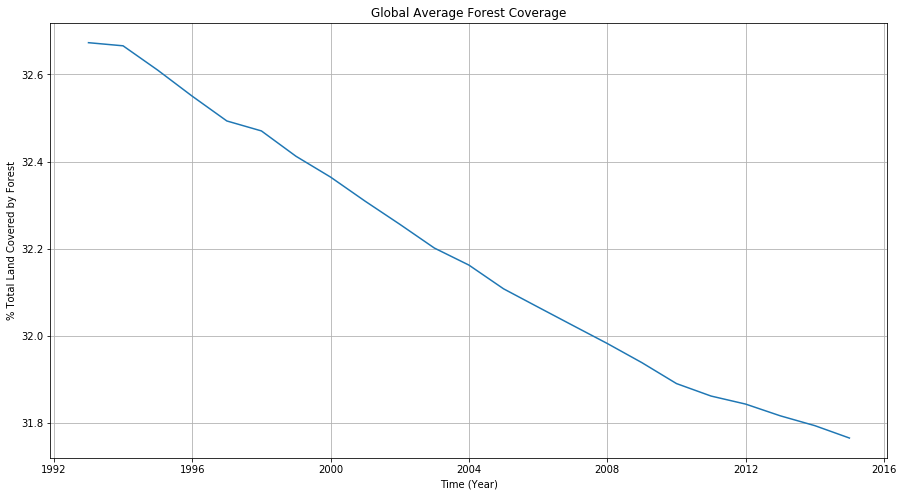

In [905]:
#average all countries together and plot the result of forest coverage over time
plt.figure(figsize=(15,8))
plt.plot(df_forest.index, df_forest.mean(axis=1))
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('% Total Land Covered by Forest')
plt.title('Global Average Forest Coverage')

This trend shows a linear decrease (negative correlation) over time of the global (186 countries) average forest coverage.

In [933]:
#calculating rate of change of forest coverage
(df_forest.mean(axis=1)['2010'].values - df_forest.mean(axis=1)['2000'].values) / 10

array([-0.04736898])

In [906]:
#number of countries in df_math dataset
df_math.shape[1]-1

12

Text(0.5, 1.0, 'Global Average 4th Grade Math Proficiency')

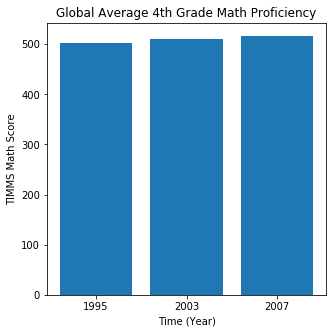

In [907]:
#average all countries together and plot the result of math proficiency over time
plt.figure(figsize=(5,5))
plt.bar([0,1,2], df_math.mean(axis=1))
plt.xticks(range(len(df_math.index)), df_math.index.year)
plt.xlabel('Time (Year)')
plt.ylabel('TIMMS Math Score')
plt.title('Global Average 4th Grade Math Proficiency')

This shows that the countries that the average of the initial 3 countries is trending upwards over time, but likely was a more well-educated subset of all countries around the globe. There were many more responses in 2007, which would have brought the average lower if they were not trimmed from the data frame.

Text(0.5, 1.0, 'Global Average Murders by Population')

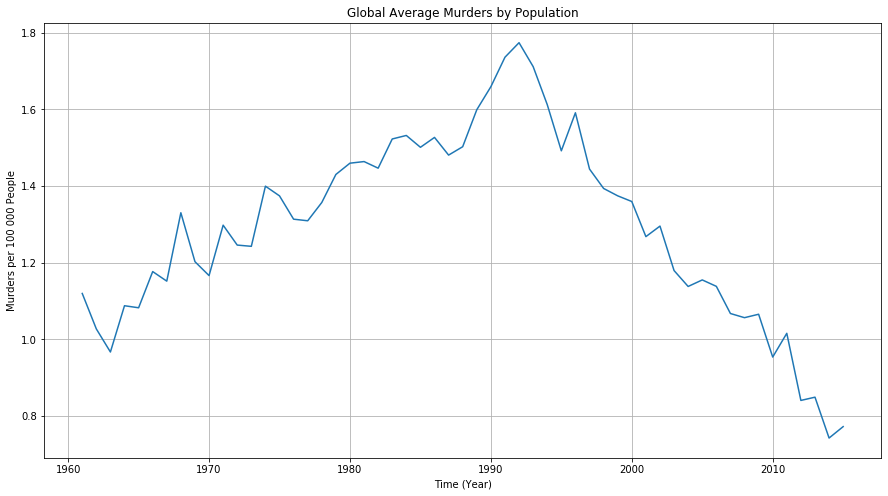

In [908]:
#average all countries together and plot the result of murders over time
plt.figure(figsize=(15,8))
plt.plot(df_murder.index, df_murder.mean(axis=1))
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('Murders per 100 000 People')
plt.title('Global Average Murders by Population')

While murders were globally on the rise in the first half of the last 55 years, they have since been on a steady decline over the last few decades.

In [950]:
#finding the peak of this curve
df_murder.mean(axis=1)[df_murder.mean(axis=1) == df_murder.mean(axis=1).max()]

1992-01-01    1.773913
dtype: float64

Text(0.5, 1.0, 'Global Average Population Density')

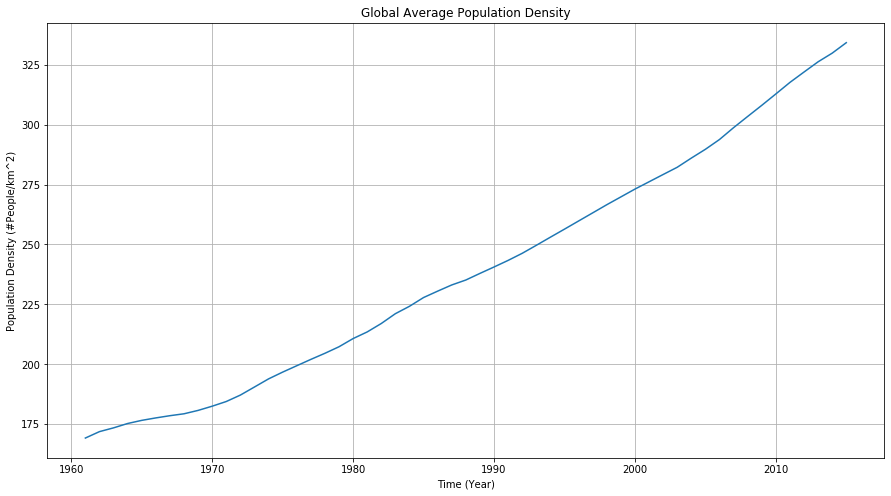

In [910]:
#average all countries together and plot the result of population density over time
plt.figure(figsize=(15,8))
plt.plot(df_pop.index, df_pop.mean(axis=1))
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('Population Density (#People/km^2)')
plt.title('Global Average Population Density')

Population density shows a strong linear correlation with time, steadily increasing on average across the globe for the last half century.

### How does a select number of countries perform compared to the global average?

In [911]:
#seeing which countries have data in all sets to be compared
countries_comp = df_math.columns & df_forest.columns & df_murder.columns & df_pop.columns
countries_comp

Index(['Australia', 'Hungary', 'Japan', 'Netherlands', 'New Zealand', 'Norway',
       'Singapore', 'United Kingdom'],
      dtype='object', name='country')

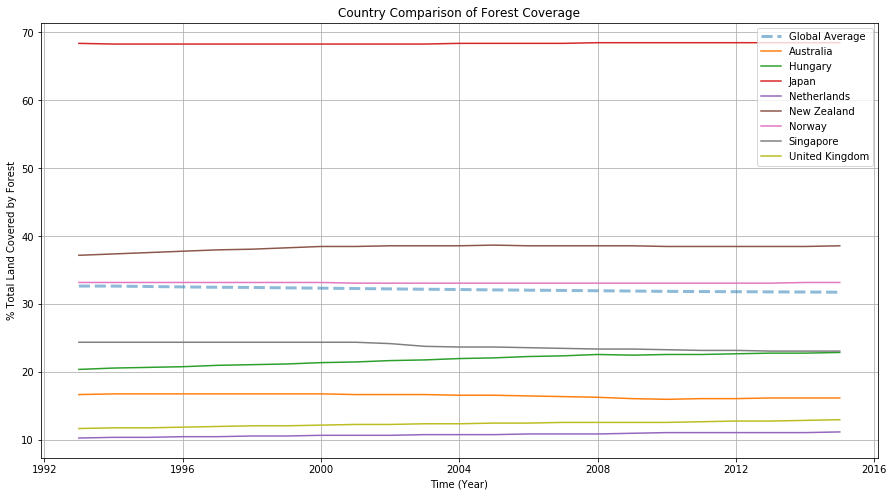

In [912]:
plt.figure(figsize=(15,8))
plt.plot(df_forest.index, df_forest.mean(axis=1), '--', linewidth=3, alpha=.5, label='Global Average')
for country in countries_comp:
    plt.plot(df_forest.index, df_forest[country], label=country)
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('% Total Land Covered by Forest')
plt.title('Country Comparison of Forest Coverage')
plt.legend()

Japan is far above the global average (close to 70%) and any of the other countries, while Norway is closest to the global average and the Netherlands has the least forest coverage. While most countries out of this set are relatively stable or declining, Hungary's forest coverage is significantly increasing by a few percent.

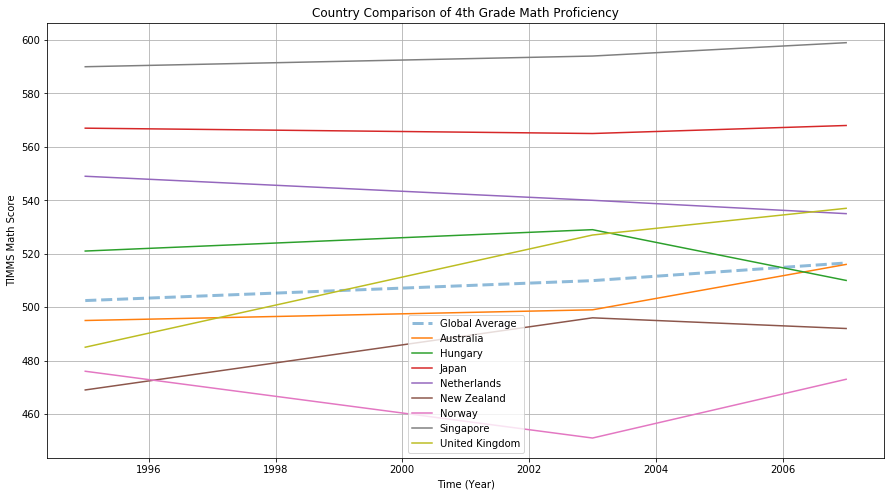

In [913]:
plt.figure(figsize=(15,8))
plt.plot(df_math.index, df_math.mean(axis=1), '--', linewidth=3, alpha=.5, label='Global Average')
for country in countries_comp:
    plt.plot(df_math.index, df_math[country], label=country)
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('TIMMS Math Score')
plt.title('Country Comparison of 4th Grade Math Proficiency')
plt.legend()

With only 3 data points per line, I would be apprehensive to make many conclusions about this data. The comparison between countries is perhaps more valuable than any trend that one might think they can perceive across three points. Asian countries takes a clear lead here, while European countries perform closer to average.

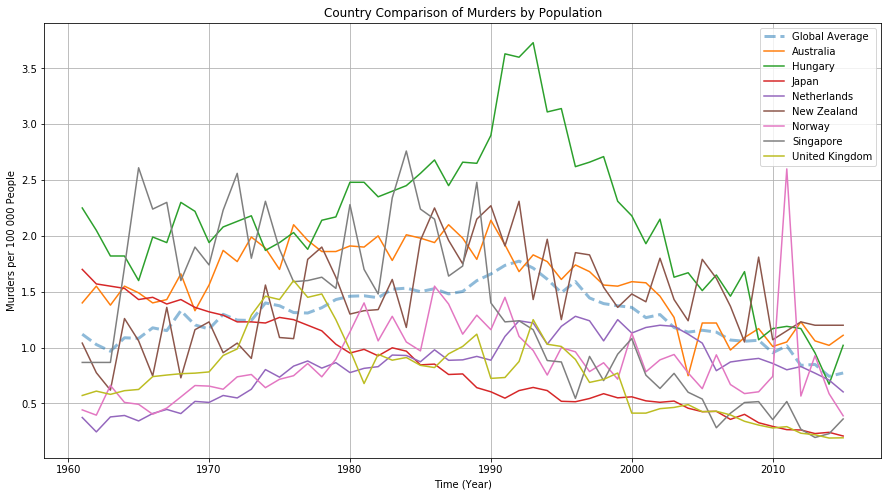

In [914]:
plt.figure(figsize=(15,8))
plt.plot(df_murder.index, df_murder.mean(axis=1), '--', linewidth=3, alpha=.5, label='Global Average')
for country in countries_comp:
    plt.plot(df_murder.index, df_murder[country], label=country)
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('Murders per 100 000 People')
plt.title('Country Comparison of Murders by Population')
plt.legend()

The volatility of this data shows how unpredictable murders can be, from a larger data perspective. A few countries stand out to me here. Hungary seems to have a massive spike around the early 90's, which makes me wonder if this was in correspondence with a time of great civil unrest. Also, Japan is one of the only countries to show both less volatility and a steady decline, which would be worth investigating. Norway has an uncharacteristic spike in 2011. Overall, murders in the world and these specific countries seem to be on the decline since the turn of the century.

In [915]:
#brief investigation into Hungary's macrovolatility
df_murder['Hungary'].max() / df_murder['Hungary'].min()

5.550595238095238

Hungary's peak murder rate was 5 times more than its minimum.

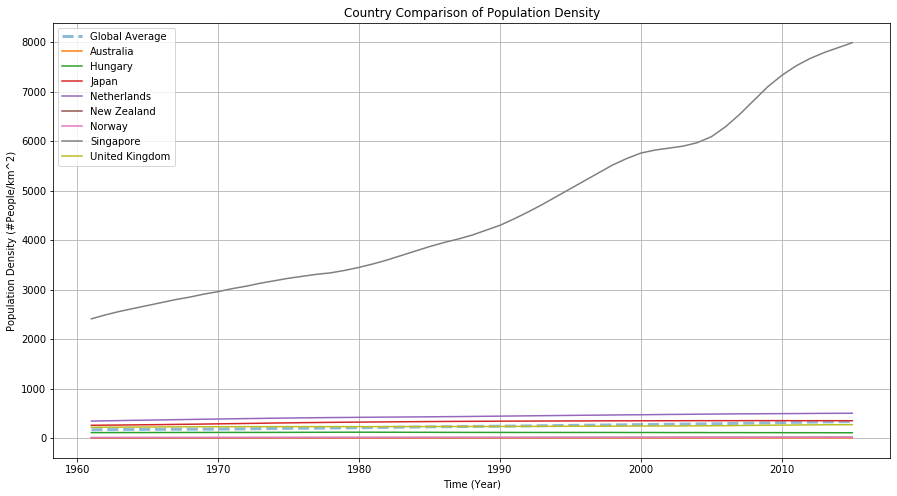

In [916]:
plt.figure(figsize=(15,8))
plt.plot(df_pop.index, df_pop.mean(axis=1), '--', linewidth=3, alpha=.5, label='Global Average')
for country in countries_comp:
    plt.plot(df_pop.index, df_pop[country], label=country)
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('Population Density (#People/km^2)')
plt.title('Country Comparison of Population Density')
plt.legend()

This shows graph proves a well-known fact that Singapore's small land area (less than 300 square miles) forces its populatoin to grow upwards (building ever-taller skyscrapers). Singapore's population density is so high that it makes it nearly impossible to see the detail and trends of the other countries, so I exclude it from the next graph

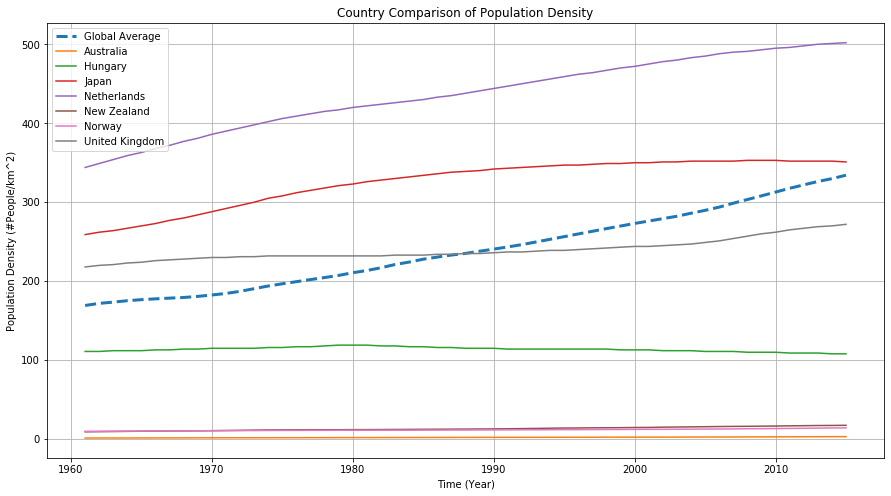

In [917]:
plt.figure(figsize=(15,8))
plt.plot(df_pop.index, df_pop.mean(axis=1), '--', linewidth=3, label='Global Average')
for country in countries_comp:
    if country != 'Singapore':
        plt.plot(df_pop.index, df_pop[country], label=country)
plt.grid(True)
plt.xlabel('Time (Year)')
plt.ylabel('Population Density (#People/km^2)')
plt.title('Country Comparison of Population Density')
plt.legend()

None of the other countries have Singapore's explosive growth of more than doubling its population density in 65 years. Netherlands, Norway, and Australia may benefit from further exploration, with their sparse populations and wide geography, but I will leave that alone for now.

### Whats correlations are there between the global averages over a set time frame?
I will observe 1995 to 2007 for all variables, normalized, since that is a timeframe shared by all. Then, I will specifically look at murder and population density from 1961 to 2015, since they both share that longer timeframe.

In [918]:
#normalization function
def normal(df):
    avg = df.mean(axis=1)
    return (avg - avg.min()) / (avg.max() - avg.min())

In [919]:
#saving the normalized data in a new df for ease of graphing
cor_forest = normal(df_forest['1995':'2007'])
cor_math = normal(df_math['1995':'2007'])
cor_murder = normal(df_murder['1995':'2007'])
cor_pop = normal(df_pop['1995':'2007'])

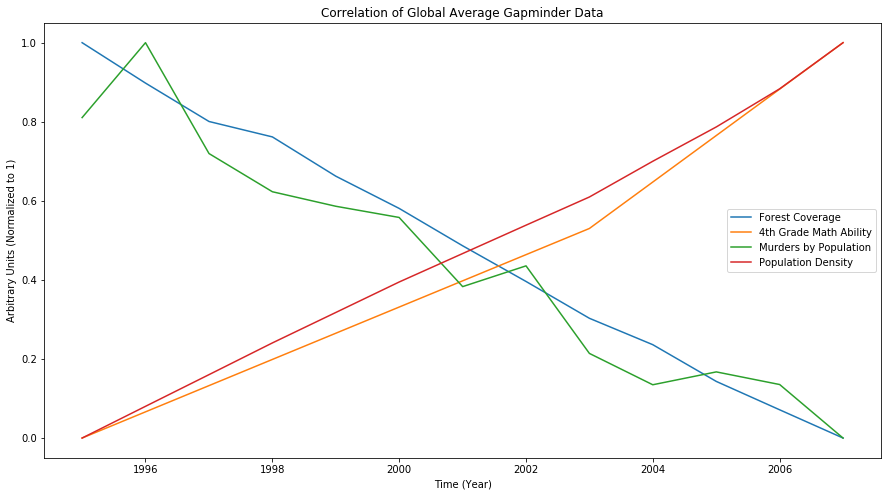

In [920]:
plt.figure(figsize=(15,8))
plt.plot(cor_forest.index,cor_forest, label='Forest Coverage')
plt.plot(cor_math.index,cor_math, label='4th Grade Math Ability')
plt.plot(cor_murder.index,cor_murder, label='Murders by Population')
plt.plot(cor_pop.index,cor_pop, label='Population Density')
plt.ylabel('Arbitrary Units (Normalized to 1)')
plt.xlabel('Time (Year)')
plt.title('Correlation of Global Average Gapminder Data')
plt.legend()

This looks like a classic case of overconstrained data to me. I wouldn't dare put much weight to anything gleaned from this. In a vaguest sense, it might show that over this decade or so, murder and forest coverage were on the decline, while math ability and population density were going up. I don't think this is a good way to assess correlation.

Text(0.5, 1.0, 'Correlation of Global Averages: Murders/Population and Population Density')

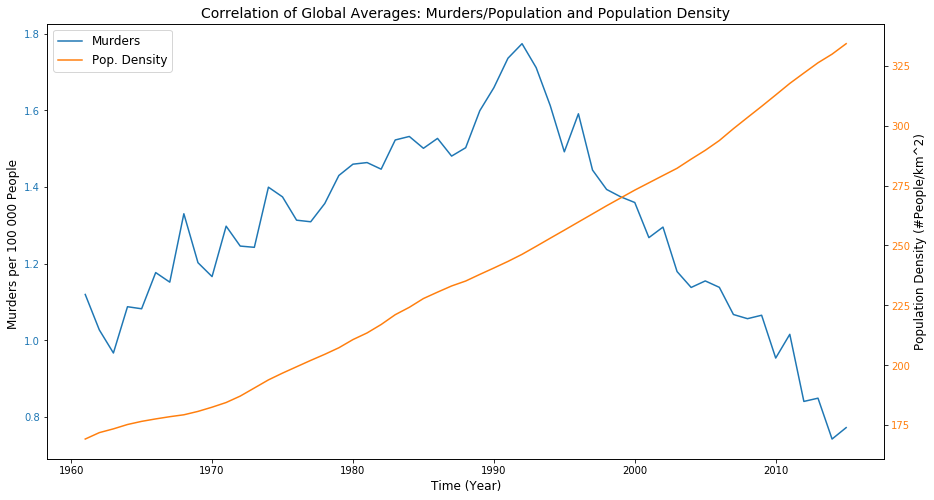

In [921]:
#looking at murder rate and population density on a dual Y-axis graph
fig = plt.figure(figsize=(15,8))
ax1 = fig.subplots()
color = 'tab:blue'
ax1.set_xlabel('Time (Year)', fontsize=12)
ax1.set_ylabel('Murders per 100 000 People ', fontsize=12)
ax1.plot(df_murder.index, df_murder.mean(axis=1), color=color, label='Murders')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Population Density (#People/km^2)', fontsize=12)
ax2.plot(df_pop.index, df_pop.mean(axis=1), color=color, label='Pop. Density')
ax2.tick_params(axis='y', labelcolor=color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=12)
plt.title('Correlation of Global Averages: Murders/Population and Population Density', fontsize=14)

This graph does not appear to show any correlation between murders and population density. I cannot conclude anything confidently due to the positive correlation up until 1990 followed by the negative correlation after that.

<a id='conclusions'></a>
## Conclusions

##### Answering Research Question 1
Forest coverage of the globe appears is on a steady decline, at a rate of about -0.05% a year. Math proficiency appears to be steadily increasing, although the pool of countries that contributed to this dataset was extremely limited (at 15). Average global murders were on the rise since 1961 and peaked around 1.773913 per 100 000 people in 1992. Since then, murders have seen a steady decline. Population density has been steadily increasing for the last 65 years.

##### Answering Research Question 2
Out of the countries I examined individually, Japan has the highest forest coverage, while the Netherlands has the lowest. Japan continued to excel in math scores, bested only by Singapore. Singapore had the highest and most accelerating population density by far. Japan was again the only exception in murders, seeing a steady decline over the decades. In contrast, the other 7 countries for the most part all followed similar trends to the global average.

##### Answering Research Question 3
The investigations I made into correlations between the Gapminder indicators have been predominantly inconclusive. I would only say my hypothesis that population density would be strongly correlated with murders per population has been disproven.

### Limitations
- The "Global Average" numbers are _not completely representative_ of the whole global human population.
>These datasets were incomplete in that they did not have data from all countries in the world. A large part of my research assumed that averaging a large subset of them (e.g., excluding outliers with large chunks of missing data) would represent the globe. Also, some countries' data was either intermittent or missing for large portions of time. Those countries were either trimmed from the relevant dataset or backfilled for at most three years.
- No extensive statistical analysis was made, so any conclusions should be viewed as inferences that were obvious from visual observation, and could be faulty due to human error.
- The 4th Grade Math data set, in particular, was extremely sparse in that it only had 3 years of data, so should be viewed as preliminary at best.
- All data was provided by Gapminder and therefore, I had no control or review of the data collection methods, which may allow for error.
- Geographical considerations could certainly play into such things as the lack of forest in Qatar and San Marino, and the high population density of Singapore. However, a map-based visualization is beyond my skills at this moment.